<a href="https://colab.research.google.com/github/rijinbaby/Text-Mining-and-Sentiment-Analysis-Project/blob/main/Hate_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pkg_resources
import subprocess
import sys
import os

REQUIRED = {
  'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 
  'pyfunctional', 'textblob', 'seaborn', 'matplotlib','tqdm'
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = REQUIRED - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
    
import numpy as np
from numpy import log, mean
import pandas as pd
from pandas import Series, DataFrame
import glob
from typing import List
from textblob import TextBlob
from typing import List, Tuple, Union
from functional import seq

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download ('stopwords')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
import nltk.sentiment.sentiment_analyzer 
from nltk.util import ngrams
import spacy
np.random.seed(1)
from nltk.tokenize import RegexpTokenizer
# package to clean text
import re

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn import preprocessing
Encode = preprocessing.LabelEncoder()
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# pd.options.display.max_seq_items = 100
# pd.set_option('display.max_rows', 100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## **Fetching data from Github**

In [ ]:
# dataset git repo
if not os.path.exists("hate-speech-dataset"):
  !git clone https://github.com/Vicomtech/hate-speech-dataset.git
    
!python -m textblob.download_corpora

Cloning into 'hate-speech-dataset'...
remote: Enumerating objects: 10785, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 10785 (delta 6), reused 0 (delta 0), pack-reused 10771
Receiving objects: 100% (10785/10785), 1.16 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (9/9), done.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading

In [ ]:
# Reading the annotations_metadata
idLabels = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "label"]]
idLabels

,file_id,label
0,12834217_1,noHate
1,12834217_2,noHate
2,12834217_3,noHate
3,12834217_4,hate
4,12834217_5,noHate
...,...,...
10939,33676864_5,noHate
10940,33677019_1,noHate
10941,33677019_2,noHate
10942,33677053_1,hate


In [ ]:
# function to read all individual text files and create a dataframe
def readData(paths: List[str], group: str):
  
  pairs = []
  for p in paths:
    
    with open(p, encoding="utf8") as f:
      file_id = p.split('/')[-1].split('.')[0]
      pairs.append((file_id, f.read(), group))
  
  return pd.DataFrame(pairs, columns=["file_id", "text", "sample"])

In [ ]:
# get the data from the files

train_data = readData(glob.glob('./hate-speech-dataset/sampled_train/*.txt'),'train')
test_data = readData(glob.glob('./hate-speech-dataset/sampled_test/*.txt'),'test')
train_data = train_data.join(idLabels.set_index('file_id'), on='file_id')
test_data = test_data.join(idLabels.set_index('file_id'), on='file_id')
stormfront_forum_dat = train_data.append(test_data).reset_index(drop=True)
sample_data = train_data.append(test_data).reset_index(drop=True)
# print label distributions
# print("Train dataset:")
# print(train_data['label'].value_counts(), "\n")
# print("Test dataset:")
# print(test_data['label'].value_counts(), "\n")


stormfront_forum_data = readData(glob.glob('./hate-speech-dataset/all_files/*.txt'),'data')
stormfront_forum_data = stormfront_forum_data.join(idLabels.set_index('file_id'), on='file_id')
print("Dataset shape:")
print(stormfront_forum_data.shape)
stormfront_forum_data.head()

Dataset shape:
(10944, 4)


,file_id,text,sample,label
0,30500254_4,Which is also why I use the open Wifi from nea...,data,noHate
1,12865091_1,Leaked phone call shows Newly appointed Jewish...,data,noHate
2,13291349_1,Pathetic scum .,data,noHate
3,14299539_4,http://kalispell.craigslist.orghttp://www.moun...,data,noHate
4,13490691_3,It is good to see it back on public display at...,data,noHate


**Alternate data download - avoid as it takes 45 minutes to run**

In [ ]:
# data = pd.read_csv('https://raw.githubusercontent.com/Vicomtech/hate-speech-dataset/master/annotations_metadata.csv')
# print(data.head(10))

# data.isna().sum().sum()  # no missing
# data.loc[:, data.isnull().any()].columns

# content =[]
# for i in data["file_id"]:
#     url = 'https://raw.githubusercontent.com/Vicomtech/hate-speech-dataset/master/all_files/' + i + '.txt'
#     text = pd.read_fwf(url, header=None,delimiter = "\t", index=False, encoding="utf8")
#     text = str(text.loc[0,0])
#     content.append(text)

# data["content"] = content
# print(data.head(10))

# data.to_csv("complete_data.csv", encoding='utf-8', index=False)

# **Data Exploration**


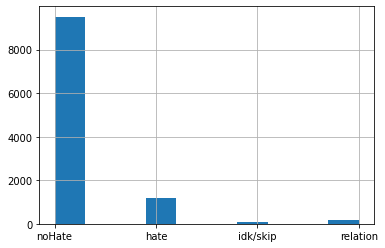

In [ ]:
stormfront_forum_data['label'].hist()

In [ ]:
stormfront_forum_data.drop(stormfront_forum_data.index[stormfront_forum_data['label'] == "idk/skip"], inplace = True)
stormfront_forum_data.drop(stormfront_forum_data.index[stormfront_forum_data['label'] == "relation"], inplace = True)

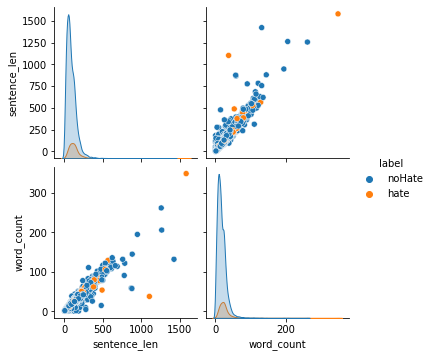

In [ ]:
strSer = stormfront_forum_data['text'].str
txtBlob = stormfront_forum_data['text'].apply(lambda s: TextBlob(s))

stormfront_forum_data['sentence_len'] = strSer.len()
stormfront_forum_data['word_count'] = strSer.split().apply(lambda ls: len(ls))

sns.pairplot(
  stormfront_forum_data[['sentence_len', 'word_count', 'label']], 
  hue="label"
)

In [ ]:
# from google.colab import files
# stormfront_forum_data.to_csv('stormfront_forum_data.csv')
# files.download('stormfront_forum_data.csv')

# **Log Likelihood Test**

In [ ]:
!python -m spacy download en_core_web_md & >/dev/null
nlp = spacy.load("en_core_web_sm")

     |████████████████████████████████| 96.4 MB 39.6 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=bf9b753f3b7ade928ac74a730df55ea376cd37ce7444b3b6b0e69c1f67914bac
  Stored in directory: /tmp/pip-ephem-wheel-cache-ss64z37a/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
def log_LhArr(src_arr: Series, ref_arr: Series):
  """
  Vectorized log-likelihood test.
  
  Parameters:
  -----------
  - src_arr: sum of tokens across all documents in the source group. Shape (1, n)
  - ref_arr: sum of tokens across all documents in the reference group. Shape (1, n)
  
  Order in which parameters are passed does not affect the results.
  """
  src_count: int = src_arr.sum()
  ref_count: int = ref_arr.sum()
  
  agg = (src_arr + ref_arr) / (src_count + ref_count)
  e1 = src_count * agg
  e2 = ref_count * agg
  
  p1 = src_arr * log(src_arr / e1)
  p2 = ref_arr * log(ref_arr / e2)

  return 2 * (p1 + p2)
  
  
def topWordsByLogLikelihood(
  docWordMatrix: DataFrame, 
  labels: List[str], 
  topN: int) -> Tuple[Series, Series]:
  """
  Prints top words sorted by log likelihood test. 
  Assumes matrix is binary (only 2 labels).
  """
  label1, label2 = set(labels)
  
  aggDf = docWordMatrix.assign(label=labels).groupby('label').sum().T
  
  aggDf = aggDf.assign(
    # difference between token counts in both categories.
    # needed to separate key tokens in each category. 
    l1Diff = aggDf[label1] - aggDf[label2], 
    l2Diff = aggDf[label2] - aggDf[label1],
    # likelihood of all tokens
    # is the likelihood of observing 'this' token in group A significantly different from B
    llikelihood = log_LhArr(aggDf[label1].replace(0, 0.01), aggDf[label2].replace(0, 0.01))
  )
  
  # boolean masks to select tokens in each category
  label1_i = aggDf['l1Diff'] > 0
  label2_i = aggDf['l1Diff'] < 0
  
  l1 = aggDf[label1_i].sort_values(by='llikelihood', ascending=False)[:topN]['llikelihood']
  l2 = aggDf[label2_i].sort_values(by='llikelihood', ascending=False)[:topN]['llikelihood']
  
  print(f"\nTop {label1.upper()} tokens by likelihood:\n")
  print(l1)

  print(f"\nTop {label2.upper()} tokens by likelihood:\n")
  print(l2)
  
  return (l1, l2)

def hateTokenizer(text: str, spacyModel=nlp):
  """
  Simple tokenizer to:
    - extract alphabetical tokens
    - remove stopwords
    - lemmatize and lowercase tokens 
  """
  doc = spacyModel(text)
  
  return seq(token for token in doc)\
    .filter(lambda t: t.is_alpha)\
    .filter_not(lambda t: t.is_stop)\
    .map(lambda t: t.lemma_.lower())\
    .to_list()

def rawCorpusToDf(
  corpus: Union[List[str], Series], 
  tokenizer=hateTokenizer, 
  idf=False) -> DataFrame:
  """Tokenize corpus and build doc-term matrix."""
  vectorizer = (
    TfidfVectorizer(tokenizer=tokenizer, lowercase=False) 
    if idf else
    CountVectorizer(tokenizer=tokenizer, lowercase=False)
  )

  X = vectorizer.fit_transform(corpus)

  return pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
count_df = rawCorpusToDf(stormfront_forum_dat['text'])
l1, l2 = topWordsByLogLikelihood(count_df, stormfront_forum_dat['label'].tolist(), 10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Top NOHATE tokens by likelihood:

youtube    34.542251
post       19.996576
meet       19.023056
pm         17.552700
sf         15.575919
music      13.569030
year       12.392726
march      12.087349
link       11.640213
video      10.407415
Name: llikelihood, dtype: float64

Top HATE tokens by likelihood:

black      56.427571
jews       54.884813
negro      44.174380
ape        33.346322
race       24.830260
scum       24.325840
mud        20.384637
non        20.364540
liberal    20.259751
white      19.448300
Name: llikelihood, dtype: float64


# **Data Processing**

In [ ]:
# collecting only the tweets from the csv file into a variable name tweet
# tweet=data.text
forum_text=stormfront_forum_data.text
forum_text

0        Which is also why I use the open Wifi from nea...
1        Leaked phone call shows Newly appointed Jewish...
2                                          Pathetic scum .
3        http://kalispell.craigslist.orghttp://www.moun...
4        It is good to see it back on public display at...
                               ...                        
10939    John Joy Tree , I agree with a lot of what you...
10940    Sorry to hear about this attack on your girlfr...
10941    oddly i would find it worst if she here black ...
10942    Here is another revealing one for the mass bra...
10943    I'd say yes , because when the whites took ove...
Name: text, Length: 10703, dtype: object

In [ ]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(forum_text):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    text_space = forum_text.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    text_name = text_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    contents = text_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = contents.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    new_content=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    new_content=new_content.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    new_content=new_content.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    content_lower = new_content.str.lower()
    
    # tokenizing
    tokenized_content = content_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_content=  tokenized_content.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the text
    tokenized_content = tokenized_content.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    # for i in range(len(tokenized_content)):
    #     tokenized_content[i] = ' '.join(tokenized_content[i])
    #     content_processed= tokenized_content
    
    tokenized_content = list(map(' '.join, tokenized_content)) 
    content_processed= tokenized_content

    return tokenized_content

processed_forum_text = preprocess(forum_text)   

stormfront_forum_data['processed_forum_text'] = processed_forum_text
print(stormfront_forum_data[["text","processed_forum_text"]].head(10))

                                                text                               processed_forum_text
0  Which is also why I use the open Wifi from nea...                     also use open wifi nearbi post
1  Leaked phone call shows Newly appointed Jewish...  leak phone call show newli appoint jewish gove...
2                                    Pathetic scum .                                        pathet scum
3  http://kalispell.craigslist.orghttp://www.moun...                                                   
4  It is good to see it back on public display at...               good see back public display kremlin
5  I can picture him as that baby monkey on the '...  pictur babi monkey save rainforest comerci whatev
6  I'd focus on the aspect of forced integration ...    focu aspect forc integr white act respons first
7  Later I went to get a beer and when I opened t...  later went get beer open door yep guess blood ...
8  I think Fyrdung is a band which was started by...  think fyrd

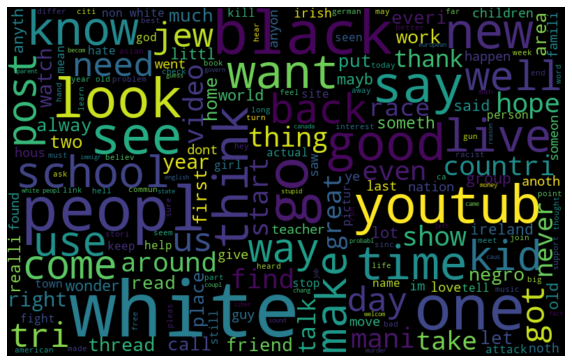

In [ ]:
# visualizing which of the word is most commonly used in the dataset
from wordcloud import WordCloud
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in stormfront_forum_data['processed_forum_text'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
#////////////////////////////////////////////////////
 
def remove_links(contents):
    '''Takes a string and removes web links from it'''
    contents = re.sub(r'http.*?(?=\s)', 'URL', contents) # remove http links
    # contents = re.sub(r'^^http[s]?://twitter\.com/(#!/)?[a-zA-Z0-9]{1,15}[/]?$','URL',contents) # accuracy improve
    # contents = re.sub('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '' ,contents)
    # contents = re.sub(r"http\S+", '',contents) #accuracy improve by removing these
    contents = re.sub(r'bit.ly/\S+', 'URL', contents) # rempve bitly links
    #contents = contents.strip('[link]') # remove [links]
    return contents

def remove_users(contents):
    '''Takes a string and removes recontents and @user information'''
    contents = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', contents) # remove recontents
    contents = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', contents) # remove contentsed at
    #contents = re.sub(r'^([a-zA-Z0-9]{1,15})$','username',contents)
    return contents
    
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_contents(contents, bigrams=False):
    contents = remove_users(contents)
    #contents = remove_links(contents)
    contents = contents.lower() # lower case
    contents = re.sub('['+my_punctuation + ']+', ' ', contents) # strip punctuation
    contents = re.sub('\s+', ' ', contents) #remove double spacing
    contents = re.sub('([0-9]+)', '', contents) # remove numbers
    #contents = re.sub('[^\w\s]','',contents)# remove special character
    contents = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', contents) # remove recontents
    contents_token_list = [word for word in contents.split(' ')
                            if word not in my_stopwords] # remove stopwords

    contents_token_list = [word_rooter(word) if '#' not in word else word
                        for word in contents_token_list] # apply word rooter
    # if bigrams:
        # contents_token_list = contents_token_list+[contents_token_list[i]+'_'+contents_token_list[i+1]
                                            # for i in range(len(contents_token_list)-1)]
    contents = ' '.join(contents_token_list)
    return contents
    
stormfront_forum_data['clean_contents'] = stormfront_forum_data.text.apply(clean_contents)

## **Models**

### **Preparing data for modeling**

In [ ]:
stormfront_forum_data.loc[stormfront_forum_data['label']=="hate",'label']=1
stormfront_forum_data.loc[stormfront_forum_data['label']=="noHate",'label']=0
stormfront_forum_data['label']=stormfront_forum_data['label'].astype(int)

In [ ]:
# def df_tokenize_2(X_train, X_test):
#     tokenizer = hateTokenizer
#     vectorizer = TfidfVectorizer(tokenizer=tokenizer, lowercase=False) #,ngram_range=(1,3)
#     X_train = vectorizer.fit_transform(X_train)
#     X_test = vectorizer.transform(X_test)
    
# #     select = SelectKBest(chi2, k=4000)
# #     X_train = select.fit_transform(X_train,y_train)
# #     X_test = select.transform(X_test,y_test)
    
#     return pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names()), pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names())

# X = stormfront_forum_data['processed_forum_text'].copy()
# y = stormfront_forum_data['label'].copy()

# X_train_n, X_test_n, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=0.2,
#                                                     stratify=y,
#                                                     random_state=11)
# X_train, X_test = df_tokenize_2(X_train_n, X_test_n)

In [ ]:
X = stormfront_forum_data['clean_contents'].copy()
y = stormfront_forum_data['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

vectorizer = TfidfVectorizer(ngram_range=(1,1))
vectorizer.fit(X_train.values.ravel())
X_train=vectorizer.transform(X_train.values.ravel())
X_test=vectorizer.transform(X_test.values.ravel())
X_train=X_train.toarray()
X_test=X_test.toarray()

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
# X_resample, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [ ]:
# SMOTE oversambling
X_train_smote, y_train_smote = SMOTE(random_state=1234).fit_resample(X_train, y_train)
y_train_smote.value_counts()

1    7605
0    7605
Name: label, dtype: int64

In [ ]:
# SMOTE + ENN is another hybrid technique where more no. of observations are removed from the sample space.
counter = Counter(y_train)
print('Before',counter)
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train,y_train)
counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 7605, 1: 957})
After Counter({1: 7565, 0: 7207})


In [ ]:
# Random Under sampling - NOT PERFORMING
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_under, y_under = undersample.fit_resample(X_train,y_train)
print(Counter(y_under))

Counter({0: 957, 1: 957})


## **Logistic Regression**

In [ ]:

pipeline = imbpipeline(steps = [#['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                # ['classifier', LogisticRegression(random_state=11,max_iter=1000)]
                                ['classifier', LogisticRegression( multi_class='ovr',solver='liblinear', random_state = 0)]
                                ])

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train_smote, y_train_smote)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.9564102564102565
Test score: 0.8757589911256423


In [ ]:
# grid_search.best_params_
# grid_search.best_score_
grid_search.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ['classifier',
                 LogisticRegression(C=10, multi_class='ovr', random_state=0,
                                    solver='liblinear')]])

In [ ]:
# Logistic Regression
classifier_lr_smenn = LogisticRegression(C=10,multi_class='ovr', solver='liblinear', random_state = 0,class_weight='balanced')
classifier_lr_smenn.fit(X_train_smenn, y_train_smenn)

y_pred_smenn = classifier_lr_smenn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_smenn))
print("Precision:",metrics.precision_score(y_test, y_pred_smenn))
print("Recall:",metrics.recall_score(y_test, y_pred_smenn))
print("F1:",metrics.f1_score(y_test, y_pred_smenn))


Accuracy: 0.8654834189631013
Precision: 0.41694915254237286
Recall: 0.5146443514644351
F1: 0.46067415730337075


In [ ]:
# Logistic Regression
classifier_lr = LogisticRegression(C=10,multi_class='ovr', solver='liblinear', random_state = 0,class_weight='balanced')
classifier_lr.fit(X_train_smote, y_train_smote)

y_pred = classifier_lr.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.8696870621205044
Precision: 0.4264705882352941
Recall: 0.48535564853556484
F1: 0.4540117416829746


In [ ]:
# # Logistic Regression
# classifier_lr = LogisticRegression(C=10,multi_class='ovr', solver='liblinear', random_state = 0,class_weight='balanced')
# classifier_lr.fit(X_under, y_under)

# y_pred = classifier_lr.predict(X_test)

# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("Precision:",metrics.precision_score(y_test, y_pred))
# print("Recall:",metrics.recall_score(y_test, y_pred))
# print("F1:",metrics.f1_score(y_test, y_pred))

In [ ]:
# # Logistic Regression
# classifier_lr = LogisticRegression(random_state=42,class_weight='balanced')
# classifier_lr.fit(X_train, y_train)

# y_pred = classifier_lr.predict(X_test)

# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("Precision:",metrics.precision_score(y_test, y_pred))
# print("Recall:",metrics.recall_score(y_test, y_pred))
# print("F1:",metrics.f1_score(y_test, y_pred))

### **Random Forest**

In [ ]:

rfc=RandomForestClassifier(random_state=42)

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)
    
# param_grid = {'classifier__C':[0.01, 0.1, 1, 10, 100]}
param_grid = { 
    'n_estimators': [10,200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
     'max_depth' : [4,5,6,7,8],
    'criterion' :['gini','entropy']
}

grid_search_rf = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search_rf.fit(X_train_smenn, y_train_smenn)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 200, 500]},
             scoring='accuracy')

In [ ]:
grid_search_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [ ]:
# {'criterion': 'entropy',
#  'max_depth': 8,
#  'max_features': 'auto',
#  'n_estimators': 200}
rfc_smenn=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='entropy',class_weight='balanced')
rfc_smenn.fit(X_train_smenn, y_train_smenn)
pred_rf_smenn=rfc_smenn.predict(X_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred_rf_smenn))
print("Precision:",metrics.precision_score(y_test, pred_rf_smenn))
print("Recall:",metrics.recall_score(y_test, pred_rf_smenn))
print("F1:",metrics.f1_score(y_test, pred_rf_smenn))

Accuracy for Random Forest on CV data:  0.8738907052779075
Precision: 0.4228855721393035
Recall: 0.35564853556485354
F1: 0.38636363636363635


In [ ]:
# rfc1=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 500, max_depth=8, criterion='gini',class_weight='balanced')
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='entropy',class_weight='balanced')
rfc1.fit(X_train_smote, y_train_smote)
pred=rfc1.predict(X_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))
print("F1:",metrics.f1_score(y_test, pred))

Accuracy for Random Forest on CV data:  0.8682858477347034
Precision: 0.3951219512195122
Recall: 0.3389121338912134
F1: 0.36486486486486486


In [ ]:
# rfc1=RandomForestClassifier(random_state=42,class_weight='balanced')  #, max_features='log2', n_estimators= 500, max_depth=8, criterion='gini',class_weight='balanced'
# rfc1.fit(X_train, y_train)
# pred=rfc1.predict(X_test)
# print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))
# print("Precision:",metrics.precision_score(y_test, pred))
# print("Recall:",metrics.recall_score(y_test, pred))
# print("F1:",metrics.f1_score(y_test, pred))

### **XGBoost**

In [ ]:
# xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
#                     silent=True, nthread=1)

xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
    

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5]
        }

grid_search_xgb = GridSearchCV(estimator=xgb,
                           param_grid=params,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search_xgb.fit(X_train_smenn.values, y_train_smenn.values)

In [ ]:
# grid_search_xgb.best_score_

In [ ]:
# cv_score = grid_search_xgb.best_score_
# test_score = grid_search_xgb.score(X_test, y_test)
# print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
xgb1=XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False,max_depth=5)
xgb1.fit(X_train_smote.values, y_train_smote.values)
pred=xgb1.predict(X_test.values)
print("Accuracy for XGB on CV data: ",accuracy_score(y_test,pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))
print("F1:",metrics.f1_score(y_test, pred))

Accuracy for XGB on CV data:  0.8766931340495095
Precision: 0.4472573839662447
Recall: 0.4435146443514644
F1: 0.4453781512605042


In [ ]:
xgb1=XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False,max_depth=5)
xgb1.fit(X_train_smenn.values, y_train_smenn.values)
pred=xgb1.predict(X_test.values)
print("Accuracy for XGB on CV data: ",accuracy_score(y_test,pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))
print("F1:",metrics.f1_score(y_test, pred))

Accuracy for XGB on CV data:  0.877627276973377
Precision: 0.451063829787234
Recall: 0.4435146443514644
F1: 0.44725738396624476


In [ ]:
# xgb1=XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False,max_depth=5)
# xgb1.fit(X_train.values, y_train.values)
# pred=xgb1.predict(X_test.values)
# print("Accuracy for XGB on CV data: ",accuracy_score(y_test,pred))
# print("Precision:",metrics.precision_score(y_test, pred))
# print("Recall:",metrics.recall_score(y_test, pred))
# print("F1:",metrics.f1_score(y_test, pred))

### **SVM**

In [ ]:
svc1=LinearSVC(verbose=10, random_state=42)
svc1.fit(X_train_smenn, y_train_smenn)
pred=svc1.predict(X_test)
print("Accuracy for SVC on CV data: ",accuracy_score(y_test,pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))
print("F1:",metrics.f1_score(y_test, pred))

[LibLinear]Accuracy for SVC on CV data:  0.8622139187295657
Precision: 0.40728476821192056
Recall: 0.5146443514644351
F1: 0.45471349353049906


In [ ]:
svc1=LinearSVC(verbose=10, random_state=42)
svc1.fit(X_train_smote, y_train_smote)
pred=svc1.predict(X_test)
print("Accuracy for SVC on CV data: ",accuracy_score(y_test,pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))
print("F1:",metrics.f1_score(y_test, pred))

[LibLinear]Accuracy for SVC on CV data:  0.8612797758056983
Precision: 0.3971631205673759
Recall: 0.4686192468619247
F1: 0.42994241842610365


In [ ]:
# svc1=LinearSVC(verbose=10, random_state=42)
# svc1.fit(X_train, y_train)
# pred=svc1.predict(X_test)
# print("Accuracy for SVC on CV data: ",accuracy_score(y_test,pred))
# print("Precision:",metrics.precision_score(y_test, pred))
# print("Recall:",metrics.recall_score(y_test, pred))
# print("F1:",metrics.f1_score(y_test, pred))

### **Sample Train and Test Data**

In [ ]:
 #from sklearn.model_selection import cross_validate
sample_data['clean_contents'] = sample_data.text.apply(clean_contents)
skf = StratifiedKFold(n_splits=5)
#tweet_df['class_label'] = Encode.fit_transform(tweet_df['label'])
x = sample_data['clean_contents']
# x =v.fit_transform(sample_data['clean_contents'].apply(lambda x: np.str_(x)))
y = sample_data['label']
skf.get_n_splits(x, y)

for train_index, test_index in skf.split(x, y):
  #LOOPS OVER 3 ITERATIONS TO SPLIT
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test= y.iloc[train_index], y.iloc[test_index]
  
result_cols = ["Classifier", "Accuracy"]
result_frame = pd.DataFrame(columns=result_cols)   
classifiers = [
                 LogisticRegression(penalty="l2", C=100, solver='liblinear'),
                 RandomForestClassifier(n_estimators=100),
                 XGBClassifier(
                     objective='multi:softmax', num_class=2
                     ),
                 LinearSVC(random_state=0, tol=1e-5)
  ]

for clf in classifiers:
    name = clf.__class__.__name__
    text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,1))), ('tfidf', TfidfTransformer(norm="l1")),
                 ('clf', clf),])      
    text_clf.fit(x_train, y_train)
    
    predicted = text_clf.predict(x_test)
    acc = metrics.accuracy_score(y_test,predicted)
    print (name+' accuracy = '+str(acc*100)+'%')
    print(classification_report(y_test, text_clf.predict(x_test), digits=4))
    acc_field = pd.DataFrame([[name, acc*100]], columns=result_cols)
    result_frame = result_frame.append(acc_field)
    

LogisticRegression accuracy = 70.0836820083682%
              precision    recall  f1-score   support

        hate     0.6791    0.7615    0.7179       239
      noHate     0.7286    0.6402    0.6815       239

    accuracy                         0.7008       478
   macro avg     0.7038    0.7008    0.6997       478
weighted avg     0.7038    0.7008    0.6997       478

RandomForestClassifier accuracy = 72.17573221757321%
              precision    recall  f1-score   support

        hate     0.7598    0.6485    0.6998       239
      noHate     0.6934    0.7950    0.7407       239

    accuracy                         0.7218       478
   macro avg     0.7266    0.7218    0.7203       478
weighted avg     0.7266    0.7218    0.7203       478

XGBClassifier accuracy = 69.24686192468619%
              precision    recall  f1-score   support

        hate     0.7875    0.5272    0.6316       239
      noHate     0.6447    0.8577    0.7361       239

    accuracy                         